# Generating the Truth (the observation values for assimilation)

We consider an identical twin experiment with syntethical truth, i.e. the truth is chosen as it would be one of the ensemble members.

We run the forward model and observe it at specific times.

In [1]:
import TruthGenerator

import Simulator
import Observation
import Statistics

In [2]:
# timestamp is used as reference key for a set-up!
import datetime
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

## Definition of grid and advection diffusion system

We solve the equation

$\frac{\partial X(t,s)}{\partial t} = \nabla \cdot D \nabla X(t,s) - v_t \cdot \nabla X(t,s) + \zeta X(t,s)  + \epsilon(t,s)$

where $\epsilon$ is $\mathcal{N}(0,\mathbf{Q})$ model error with a Matern like correlation structure and a damped variance. 

As parameters we choose 
- $D=0.25$
- $\mathbf{v} = (0.5,0.5)^\top$
- $\zeta=-0.0001$.

For the numerical solution a temporal forward amd spatial central finite-difference scheme is employed such that 

$\mathbf{X}_{t+1} = \mathbf{M}\mathbf{X}_t + \mathbf
{\epsilon}_t$

for a simulator time step $dt=0.1$. 

In [3]:
grid = Simulator.Grid(nx=50,ny=30, dx=0.1,dy=0.1)
simulator = Simulator.Simulator(grid, 
                                D=0.25, 
                                v=[0.5,0.5],
                                zeta=-0.0001,
                                dt=0.01,
                                noise_matern_phi=2.0,
                                noise_stddev=0.1)

## Definition of prior distribution

Gaussian distribution $\mathbf{X}_0\sim\mathcal{N}(\mathbf{\mu}_0, \mathbf{\Sigma}_0)$ 

where $\mathbf{\mu}_0 = 10 + "bell"$ and a Matern like covariance 


In [4]:
prior_args = {"mean_upshift"     : 10.0, #Should be chosen that samples are non-negative everywhere
                "bell_center"    : [0.25,0.25],
                "bell_sharpness" : 0.1,
                "bell_scaling"   : 5.0,
                "matern_phi"     : 1.0, #Should be chosen such that correlation range = 1/4 to 1/3 of domain
                "stddev"         : 1.0}

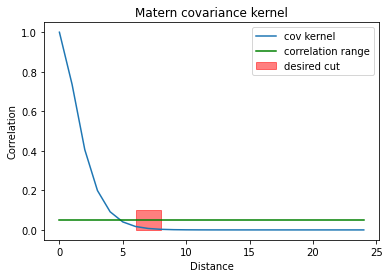

In [5]:
TruthGenerator.plot_kernel(grid, prior_args)

## Prior generation

In [6]:
statistics = Statistics.Statistics(simulator, 1)

In [7]:
statistics.set_prior(prior_args)

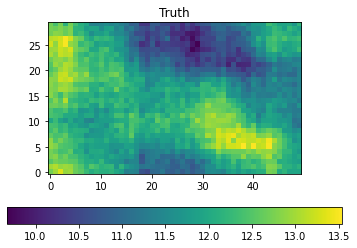

In [8]:
import numpy as np
vmin = np.min(statistics.mean)
vmax = np.max(statistics.mean)

TruthGenerator.plot_truth(statistics.mean, grid, vmin=vmin, vmax=vmax)

## Setting observation moorings

Fixed positions observers

$$y_t = \mathbf{H}\mathbf{X_t} + \tau$$ 

where $\tau\sim\mathcal{N}(0,\mathbf{R})$ is Gaussian zero-mean iid noise with $\mathbf{R}=\sigma_\tau \mathbf{Id}$

In [9]:
observation = Observation.Observation(grid, noise_level=0.01)

In [10]:
import numpy as np

def observation_positions(grid, freq):
    poses = []
    for j in range(int(np.ceil(grid.ny/freq))):
        for i in range(int(np.ceil(grid.nx/freq))):
            poses.append([i*freq,j*freq])
    return poses

In [11]:
poses = observation_positions(grid, freq=10)
observation.set_positions(poses)

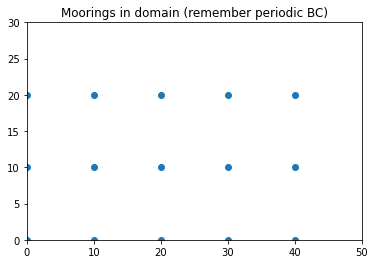

In [12]:
observation.plot_positions()

## Writing set-up to file

In [13]:
TruthGenerator.to_file(timestamp, simulator, prior_args, observation)

-----------------------------------------------------
-----------------------------------------------------
-----------------------------------------------------

## Temporal evolution of model and observe

One model time step consists of `nt`=25 constant simulator time steps

Model time step:  0


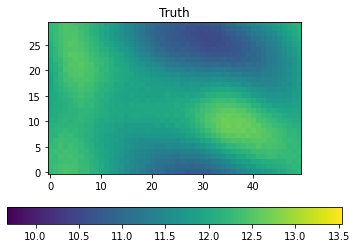

Model time step:  1


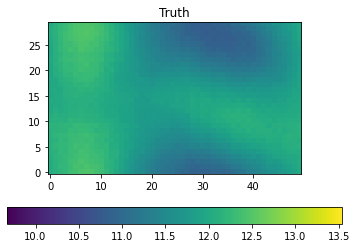

Model time step:  2


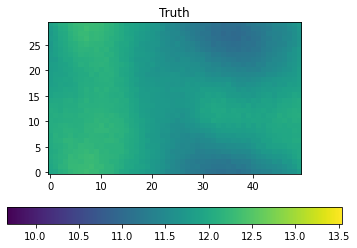

Model time step:  3


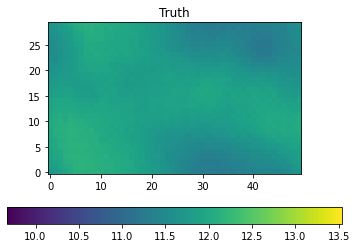

Model time step:  4


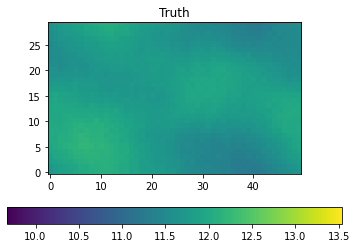

Model time step:  5


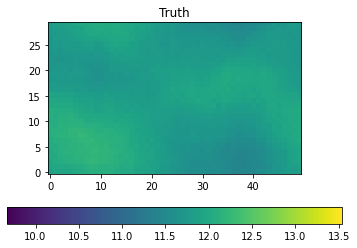

Model time step:  6


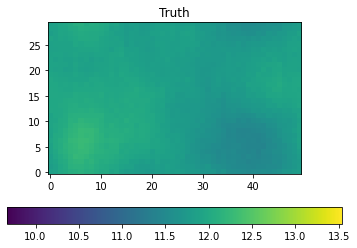

Model time step:  7


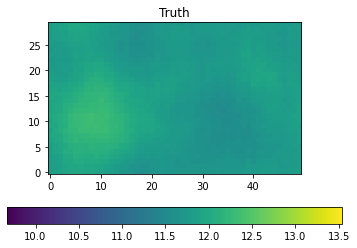

Model time step:  8


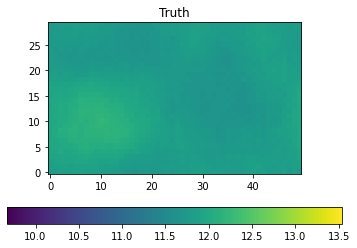

Model time step:  9


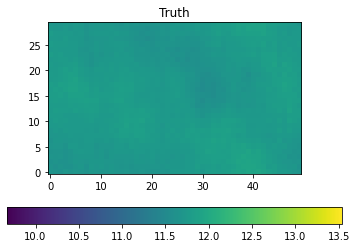

In [14]:
for t in range(10):
    print("Model time step: ", t)
    statistics.propagate(nt=25)
    observation.observe(statistics.mean)
    TruthGenerator.plot_truth(statistics.mean, grid, vmin=vmin, vmax=vmax)

## Store observations

Since the observed values are realisations of an permanent setup they get equipped with an independent timestamp as key

In [15]:
obs_timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")

In [16]:
observation.values_to_file(timestamp, obs_timestamp)